In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:

home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
import analysis.mathematical_functions.funcs as funcs

In [3]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=2.0)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['axes.labelsize']=20
plt.rcParams['legend.fontsize']= 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 20

In [6]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,100000)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [12]:
fit_func = lambda x,y,z, c, R0, kappa: R0/(1+kappa*y) * (x + (1-c)*z) -1 
c_d = lambda d,xi: np.exp(-d/xi)
rho_d = lambda d, dbar: np.exp(-(d-1)/dbar)/dbar

In [43]:
def get_E_early_late_kappa(dbar,xi, R0, kappa, N=1e9, without_peak = False):
    ds = np.arange(1,10*dbar)    
    rhos = rho_d(ds,dbar).reshape(-1,1)

    delta = dbar/xi
    delta/=(1+delta)
    
    ts, (S,I) = integrate_trajectory(R0,kappa,N)
    dt= ts[1]-ts[0]
    xs,ys= S/N,I/N
    zs = 1-xs-ys
    zp = zs[np.argmax(ys)]
    if without_peak:
        inds_early = np.argwhere(zs<1/(2*R0*kappa)).flatten()
        inds_late = np.argwhere(zs>zp+ 1/(2*R0*kappa)).flatten() 
    else:
        inds_early = np.argwhere(zs<zp).flatten()
        inds_late = np.argwhere(zs>zp).flatten()

    fit_d_t_small = np.array( [fit_func(xs,ys,zs,c_d(d,xi), R0, kappa) for d in ds])
    p_surv_d_t_small = np.array([get_p_surv_inv_int(fit_d, ts[1]-ts[0],reg=1e-5) for fit_d in fit_d_t_small])

    bare_emergence_t  = np.sum(ys*p_surv_d_t_small *rhos, axis=0)
    E_early = delta/(dt*np.sum(bare_emergence_t[inds_early]))
    E_late = delta/(dt*np.sum(bare_emergence_t[inds_late]))
    
    return E_early, E_late

        

In [48]:
R0 = 2.5
dbar = 10
xi= 50

delta = dbar/xi
kappa_s = np.logspace(-1,3,20)

E_early_wo_peak, E_late_wo_peak = np.array([get_E_early_late_kappa(dbar,xi, R0, kappa, N=1e9, without_peak = True) for kappa in tqdm(kappa_s)]).T

E_early_w_peak, E_late_w_peak = np.array([get_E_early_late_kappa(dbar,xi, R0, kappa, N=1e9, without_peak = False) for kappa in tqdm(kappa_s)]).T



  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_6297/2668387856.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  E_late = delta/(dt*np.sum(bare_emergence_t[inds_late]))
100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


In [49]:
delta = dbar/xi

  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_6297/2668387856.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  E_late = delta/(dt*np.sum(bare_emergence_t[inds_late]))
100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


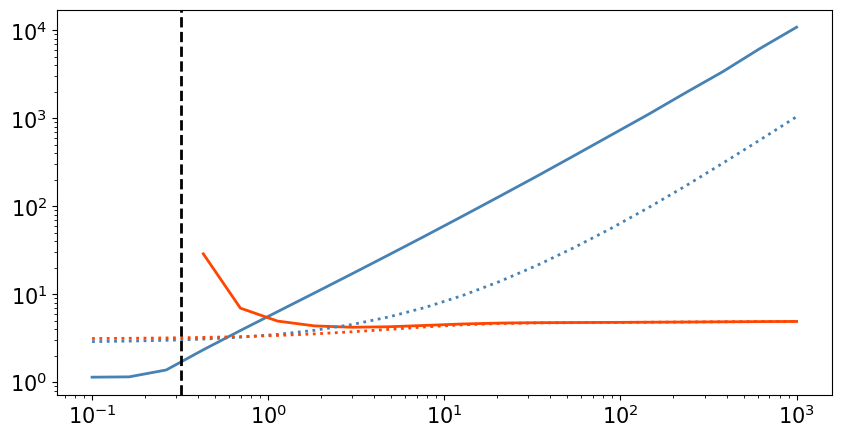

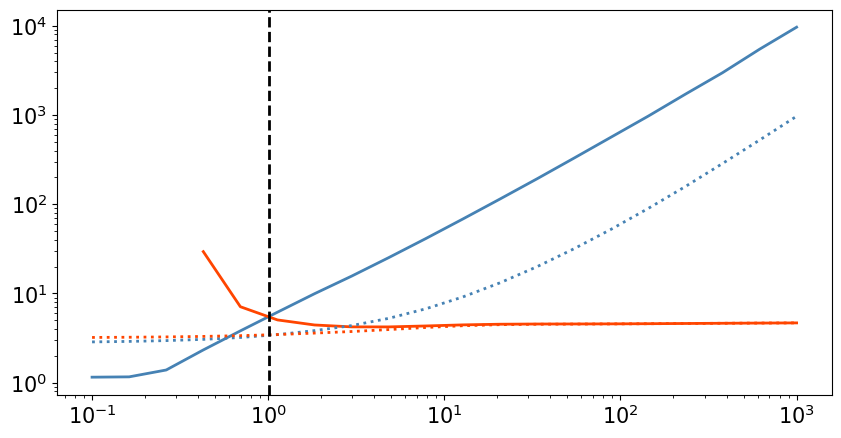

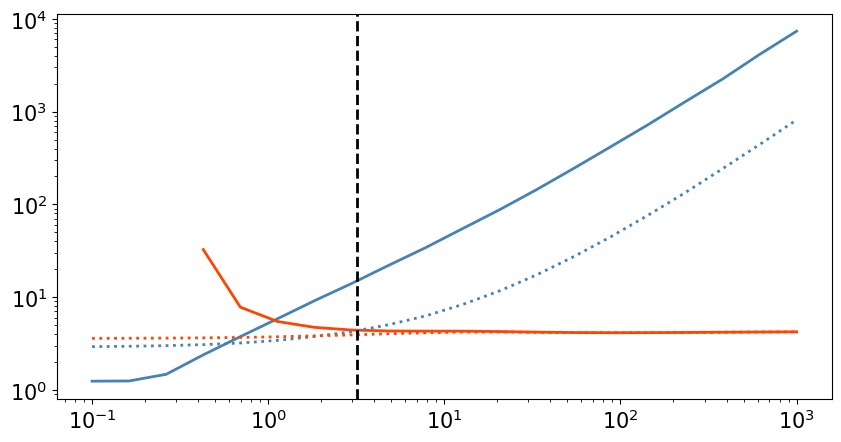

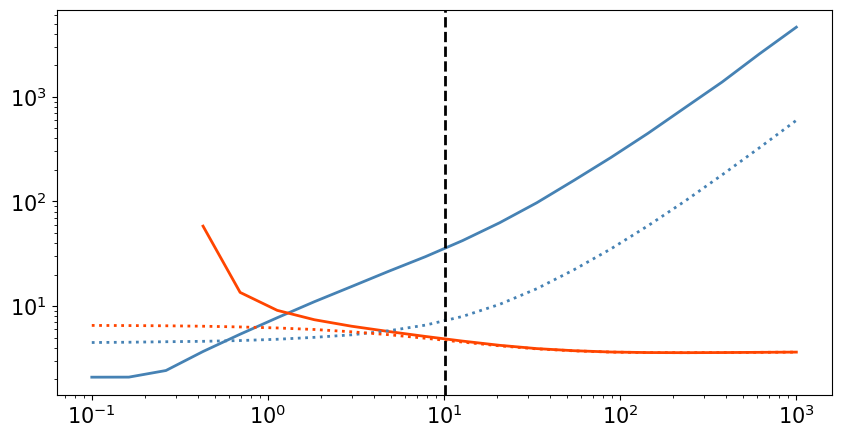

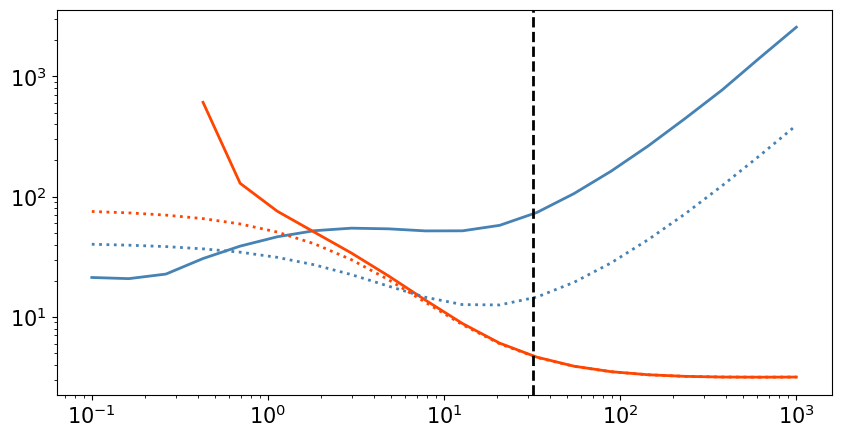

In [57]:
xi_s = np.logspace(0,2,5)
for xi in xi_s:
    delta = dbar/xi
    kappa_s = np.logspace(-1,3,20)

    E_early_wo_peak, E_late_wo_peak = np.array([get_E_early_late_kappa(dbar,xi, R0, kappa, N=1e9, without_peak = True) for kappa in tqdm(kappa_s)]).T
    E_early_w_peak, E_late_w_peak = np.array([get_E_early_late_kappa(dbar,xi, R0, kappa, N=1e9, without_peak = False) for kappa in tqdm(kappa_s)]).T

    fig,ax= plt.subplots(1,1,figsize=(10,5))
    ax.plot(kappa_s, (R0-1)/R0*E_early_wo_peak, label = 'Early emergence without peak',color='steelblue')
    ax.plot(kappa_s, E_late_wo_peak, label = 'Late emergence without peak',color='orangered')

    ax.plot(kappa_s, (R0-1)/R0*E_early_w_peak, label = 'Early emergence with peak',ls=':',color='steelblue')
    ax.plot(kappa_s, E_late_w_peak, label = 'Late emergence with peak',ls=':',color='orangered')

    early_approx = 1/(delta*kappa_s)

    ax.set_xscale('log')
    ax.set_yscale('log')

    kappa_star  = np.log(2)/delta * (R0/(R0-1))**3
    ax.axvline(kappa_star, color='k', ls='--')
